# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [84]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [85]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

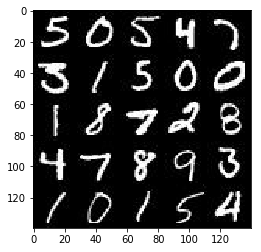

In [86]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

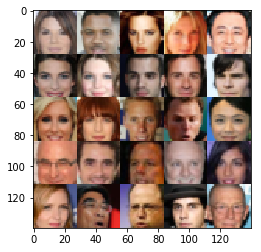

In [87]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [88]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [89]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [90]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.layers.dropout(layer1, 0.5)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.layers.dropout(layer2, 0.5)
        layer2 = tf.maximum(alpha * layer2, layer2)

        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.layers.dropout(layer3, 0.5)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        flat = tf.reshape(layer3, (-1, 4*4*256))
        flat = tf.layers.dropout(flat, 0.2)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [91]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer1 = tf.layers.dense(z, 2*2*256, kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.reshape(layer1, (-1, 2, 2, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.layers.dropout(layer1, 0.5, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='valid',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.layers.dropout(layer2, 0.5, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.layers.dropout(layer3, 0.5, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [92]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real * 0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [93]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [94]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [100]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                batch_images = batch_images * 2
                z_batch = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: z_batch, input_real: batch_images, learn_rate: learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: z_batch, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_batch})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.5593
Epoch 1/2... Discriminator Loss: 2.2275... Generator Loss: 0.1614
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 0.1833... Generator Loss: 2.1499
Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 1.6295
Epoch 1/2... Discriminator Loss: 0.1832... Generator Loss: 3.5622
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.6496
Epoch 1/2... Discriminator Loss: 0.6474... Generator Loss: 1.6350


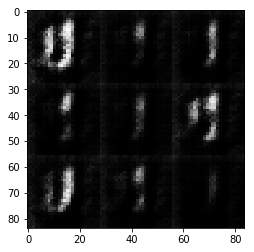

Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.2998
Epoch 1/2... Discriminator Loss: 1.5989... Generator Loss: 6.1745
Epoch 1/2... Discriminator Loss: 0.3993... Generator Loss: 3.0723
Epoch 1/2... Discriminator Loss: 0.5696... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 0.2990... Generator Loss: 2.0812
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 3.6376
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 2.8282
Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 2.2367
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 4.4757
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.8426


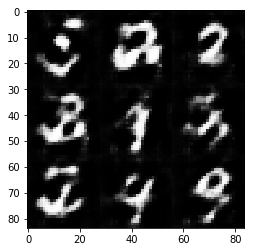

Epoch 1/2... Discriminator Loss: 0.7277... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 0.6644... Generator Loss: 2.7506
Epoch 1/2... Discriminator Loss: 0.3544... Generator Loss: 3.0285
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 2.6295
Epoch 1/2... Discriminator Loss: 0.4368... Generator Loss: 3.9192
Epoch 1/2... Discriminator Loss: 2.0179... Generator Loss: 6.1851
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 1.9437
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 4.6722
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 1.7475


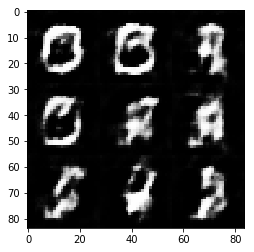

Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 2.3363
Epoch 1/2... Discriminator Loss: 0.4323... Generator Loss: 1.4635
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 2.6198
Epoch 1/2... Discriminator Loss: 1.8242... Generator Loss: 5.1914
Epoch 1/2... Discriminator Loss: 0.4430... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 1.4249
Epoch 1/2... Discriminator Loss: 0.4344... Generator Loss: 2.8964
Epoch 1/2... Discriminator Loss: 0.2465... Generator Loss: 2.2277


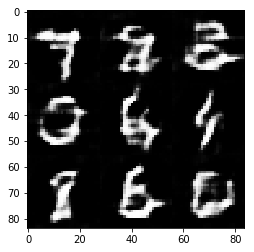

Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 0.3893... Generator Loss: 1.9606
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.8063... Generator Loss: 0.2222
Epoch 1/2... Discriminator Loss: 0.7572... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 0.4967... Generator Loss: 1.5073
Epoch 1/2... Discriminator Loss: 0.3455... Generator Loss: 1.8058
Epoch 1/2... Discriminator Loss: 0.2534... Generator Loss: 2.3314
Epoch 1/2... Discriminator Loss: 2.0231... Generator Loss: 0.2891
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 1.3389


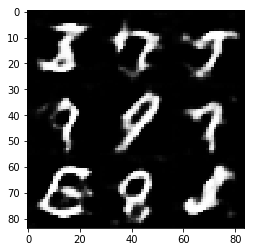

Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 3.8044
Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 1.2805
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 2.0934
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.3371
Epoch 1/2... Discriminator Loss: 0.4074... Generator Loss: 2.9170
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 3.1836
Epoch 1/2... Discriminator Loss: 0.5208... Generator Loss: 1.9840
Epoch 1/2... Discriminator Loss: 0.3805... Generator Loss: 2.8701
Epoch 1/2... Discriminator Loss: 0.2259... Generator Loss: 3.6567


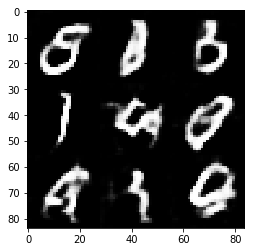

Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 1.4064
Epoch 1/2... Discriminator Loss: 0.2358... Generator Loss: 2.2900
Epoch 1/2... Discriminator Loss: 0.3558... Generator Loss: 2.0696
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 5.0735
Epoch 1/2... Discriminator Loss: 0.2940... Generator Loss: 2.8567
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 4.6704
Epoch 1/2... Discriminator Loss: 0.4854... Generator Loss: 3.0080
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 2.9423... Generator Loss: 7.1008
Epoch 1/2... Discriminator Loss: 0.5414... Generator Loss: 1.4475


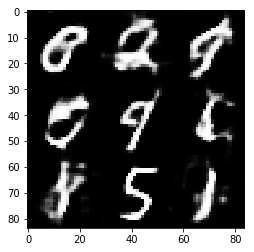

Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 3.6204
Epoch 1/2... Discriminator Loss: 0.2479... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 2.1642... Generator Loss: 0.2664
Epoch 1/2... Discriminator Loss: 0.2772... Generator Loss: 2.4403
Epoch 1/2... Discriminator Loss: 0.2165... Generator Loss: 2.3532
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 1.5508
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 5.1464
Epoch 1/2... Discriminator Loss: 0.2636... Generator Loss: 3.0585
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.9670
Epoch 1/2... Discriminator Loss: 0.2084... Generator Loss: 3.4481


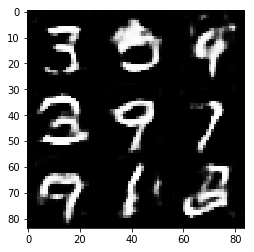

Epoch 1/2... Discriminator Loss: 2.0778... Generator Loss: 0.2231
Epoch 1/2... Discriminator Loss: 0.2074... Generator Loss: 2.8822
Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 1.4661
Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 4.6142
Epoch 1/2... Discriminator Loss: 0.2643... Generator Loss: 2.1118
Epoch 1/2... Discriminator Loss: 0.1542... Generator Loss: 4.1298
Epoch 1/2... Discriminator Loss: 0.3216... Generator Loss: 2.0780
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 5.7136
Epoch 1/2... Discriminator Loss: 0.1403... Generator Loss: 2.9809
Epoch 1/2... Discriminator Loss: 0.1330... Generator Loss: 3.3704


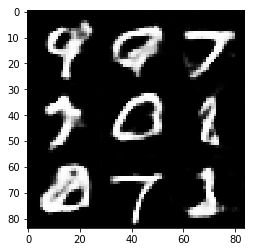

Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 5.4857
Epoch 1/2... Discriminator Loss: 0.2682... Generator Loss: 1.7889
Epoch 1/2... Discriminator Loss: 0.0869... Generator Loss: 3.2266
Epoch 1/2... Discriminator Loss: 0.1027... Generator Loss: 2.8506
Epoch 1/2... Discriminator Loss: 0.1477... Generator Loss: 3.5197
Epoch 1/2... Discriminator Loss: 0.2492... Generator Loss: 2.7918
Epoch 1/2... Discriminator Loss: 0.0778... Generator Loss: 3.7184
Epoch 1/2... Discriminator Loss: 0.1209... Generator Loss: 2.8713
Epoch 1/2... Discriminator Loss: 0.0580... Generator Loss: 3.1810
Epoch 1/2... Discriminator Loss: 3.2435... Generator Loss: 6.2980


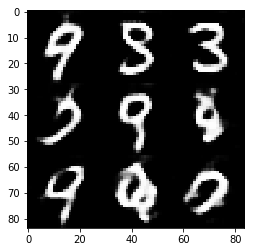

Epoch 1/2... Discriminator Loss: 0.3493... Generator Loss: 2.8224
Epoch 1/2... Discriminator Loss: 0.3344... Generator Loss: 1.9551
Epoch 1/2... Discriminator Loss: 0.4123... Generator Loss: 2.8791
Epoch 1/2... Discriminator Loss: 0.2167... Generator Loss: 3.4501
Epoch 1/2... Discriminator Loss: 0.4393... Generator Loss: 4.9926
Epoch 1/2... Discriminator Loss: 0.1530... Generator Loss: 3.7732
Epoch 1/2... Discriminator Loss: 0.0584... Generator Loss: 4.4362
Epoch 1/2... Discriminator Loss: 0.2474... Generator Loss: 2.8827
Epoch 1/2... Discriminator Loss: 0.0712... Generator Loss: 3.4338
Epoch 1/2... Discriminator Loss: 0.0201... Generator Loss: 4.2626


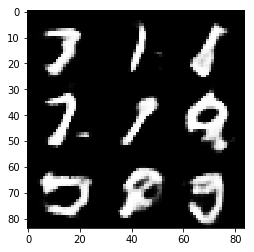

Epoch 1/2... Discriminator Loss: 0.1878... Generator Loss: 2.7771
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 0.4273... Generator Loss: 5.4795
Epoch 1/2... Discriminator Loss: 0.3635... Generator Loss: 1.9451
Epoch 1/2... Discriminator Loss: 0.2583... Generator Loss: 2.3925
Epoch 1/2... Discriminator Loss: 0.3846... Generator Loss: 4.7695
Epoch 1/2... Discriminator Loss: 0.1885... Generator Loss: 2.3375
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 0.3178... Generator Loss: 4.5427
Epoch 1/2... Discriminator Loss: 2.3546... Generator Loss: 6.8751


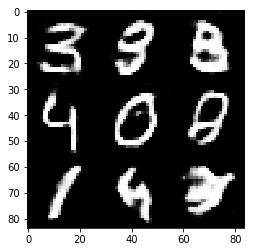

Epoch 1/2... Discriminator Loss: 0.3073... Generator Loss: 1.8962
Epoch 1/2... Discriminator Loss: 0.1062... Generator Loss: 3.3059
Epoch 1/2... Discriminator Loss: 0.1028... Generator Loss: 2.6665
Epoch 1/2... Discriminator Loss: 0.2227... Generator Loss: 2.6626
Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 2.1593
Epoch 1/2... Discriminator Loss: 0.1721... Generator Loss: 2.7289
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 1.5325
Epoch 1/2... Discriminator Loss: 0.4773... Generator Loss: 3.4577
Epoch 1/2... Discriminator Loss: 0.1709... Generator Loss: 2.1587
Epoch 1/2... Discriminator Loss: 0.2197... Generator Loss: 2.9301


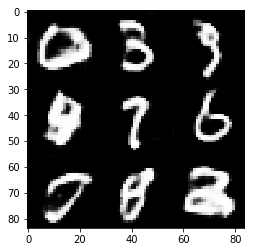

Epoch 1/2... Discriminator Loss: 0.2447... Generator Loss: 3.3716
Epoch 1/2... Discriminator Loss: 0.1362... Generator Loss: 2.7577
Epoch 1/2... Discriminator Loss: 0.2264... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 0.1708... Generator Loss: 1.6624
Epoch 1/2... Discriminator Loss: 0.0616... Generator Loss: 3.6880
Epoch 1/2... Discriminator Loss: 5.3218... Generator Loss: 9.4199
Epoch 1/2... Discriminator Loss: 0.5458... Generator Loss: 1.0244
Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.2951
Epoch 1/2... Discriminator Loss: 0.2907... Generator Loss: 1.4406
Epoch 1/2... Discriminator Loss: 0.2454... Generator Loss: 2.3007


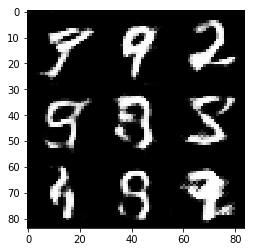

Epoch 1/2... Discriminator Loss: 0.1512... Generator Loss: 3.9942
Epoch 1/2... Discriminator Loss: 0.0780... Generator Loss: 3.4148
Epoch 1/2... Discriminator Loss: 0.1298... Generator Loss: 3.4917
Epoch 1/2... Discriminator Loss: 0.0539... Generator Loss: 3.7646
Epoch 1/2... Discriminator Loss: 0.1651... Generator Loss: 3.1277
Epoch 1/2... Discriminator Loss: 0.0752... Generator Loss: 3.4723
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 5.4394
Epoch 1/2... Discriminator Loss: 0.0534... Generator Loss: 3.9655
Epoch 1/2... Discriminator Loss: 0.0713... Generator Loss: 2.8681
Epoch 1/2... Discriminator Loss: 0.1882... Generator Loss: 2.2598


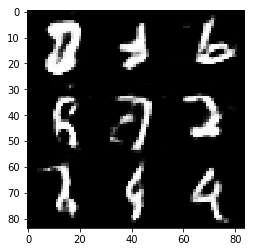

Epoch 1/2... Discriminator Loss: 0.0509... Generator Loss: 3.9993
Epoch 1/2... Discriminator Loss: 0.2932... Generator Loss: 2.1536
Epoch 1/2... Discriminator Loss: 0.0723... Generator Loss: 3.4920
Epoch 1/2... Discriminator Loss: 0.1448... Generator Loss: 3.2953
Epoch 1/2... Discriminator Loss: 0.1197... Generator Loss: 3.5407
Epoch 1/2... Discriminator Loss: 0.0639... Generator Loss: 3.6389
Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 3.5113
Epoch 1/2... Discriminator Loss: 0.6893... Generator Loss: 4.4361
Epoch 1/2... Discriminator Loss: 0.1855... Generator Loss: 2.8741
Epoch 1/2... Discriminator Loss: 0.1565... Generator Loss: 3.9428


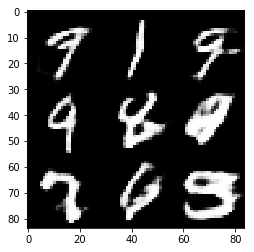

Epoch 1/2... Discriminator Loss: 0.0979... Generator Loss: 4.1949
Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 5.1727
Epoch 1/2... Discriminator Loss: 0.1724... Generator Loss: 2.9611
Epoch 1/2... Discriminator Loss: 0.0586... Generator Loss: 3.7058
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 0.2615... Generator Loss: 2.7782
Epoch 1/2... Discriminator Loss: 0.2436... Generator Loss: 2.5034
Epoch 1/2... Discriminator Loss: 0.1289... Generator Loss: 2.7829
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 1.9555
Epoch 1/2... Discriminator Loss: 0.1639... Generator Loss: 5.2181


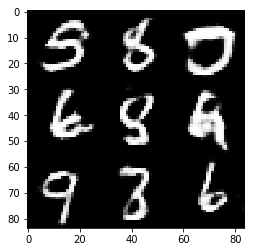

Epoch 1/2... Discriminator Loss: 0.0757... Generator Loss: 4.7459
Epoch 1/2... Discriminator Loss: 0.2268... Generator Loss: 2.8478
Epoch 1/2... Discriminator Loss: 0.0625... Generator Loss: 4.2839
Epoch 1/2... Discriminator Loss: 0.0275... Generator Loss: 3.9808
Epoch 1/2... Discriminator Loss: 0.1047... Generator Loss: 4.3229
Epoch 1/2... Discriminator Loss: 0.1067... Generator Loss: 3.2902
Epoch 1/2... Discriminator Loss: 0.1958... Generator Loss: 4.0934
Epoch 1/2... Discriminator Loss: 0.0489... Generator Loss: 3.4936
Epoch 1/2... Discriminator Loss: 2.5644... Generator Loss: 0.2284
Epoch 1/2... Discriminator Loss: 0.3988... Generator Loss: 1.9510


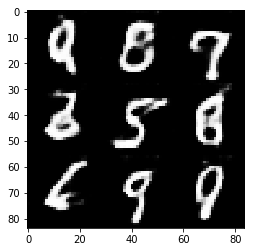

Epoch 1/2... Discriminator Loss: 0.2459... Generator Loss: 3.6178
Epoch 1/2... Discriminator Loss: 0.3211... Generator Loss: 4.7397
Epoch 1/2... Discriminator Loss: 0.0629... Generator Loss: 3.1358
Epoch 1/2... Discriminator Loss: 0.0992... Generator Loss: 4.1667
Epoch 1/2... Discriminator Loss: 0.1362... Generator Loss: 3.9814
Epoch 1/2... Discriminator Loss: 0.0685... Generator Loss: 5.2644
Epoch 1/2... Discriminator Loss: 0.0657... Generator Loss: 4.2294
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 0.4200... Generator Loss: 3.6648
Epoch 2/2... Discriminator Loss: 0.3030... Generator Loss: 3.0443


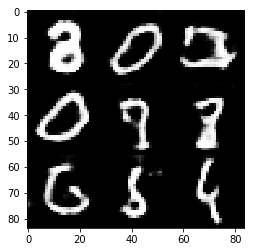

Epoch 2/2... Discriminator Loss: 0.3965... Generator Loss: 1.6978
Epoch 2/2... Discriminator Loss: 0.0513... Generator Loss: 4.1478
Epoch 2/2... Discriminator Loss: 0.0381... Generator Loss: 3.8831
Epoch 2/2... Discriminator Loss: 0.0593... Generator Loss: 4.7298
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.3117
Epoch 2/2... Discriminator Loss: 0.1860... Generator Loss: 2.3454
Epoch 2/2... Discriminator Loss: 0.1142... Generator Loss: 2.5890
Epoch 2/2... Discriminator Loss: 0.0728... Generator Loss: 4.9319
Epoch 2/2... Discriminator Loss: 0.0902... Generator Loss: 5.1719
Epoch 2/2... Discriminator Loss: 0.0907... Generator Loss: 3.5204


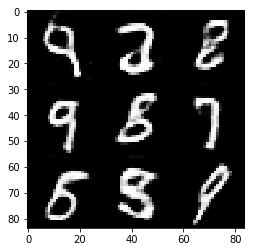

Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 4.9661
Epoch 2/2... Discriminator Loss: 0.0686... Generator Loss: 4.9304
Epoch 2/2... Discriminator Loss: 0.0511... Generator Loss: 4.7578
Epoch 2/2... Discriminator Loss: 0.1120... Generator Loss: 3.1603
Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 4.5435
Epoch 2/2... Discriminator Loss: 0.0366... Generator Loss: 4.8127
Epoch 2/2... Discriminator Loss: 0.0513... Generator Loss: 3.5754
Epoch 2/2... Discriminator Loss: 0.0332... Generator Loss: 5.0790
Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 3.8007
Epoch 2/2... Discriminator Loss: 0.0189... Generator Loss: 5.5981


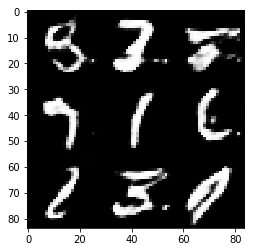

Epoch 2/2... Discriminator Loss: 0.0199... Generator Loss: 6.5308
Epoch 2/2... Discriminator Loss: 0.0205... Generator Loss: 5.4705
Epoch 2/2... Discriminator Loss: 0.0438... Generator Loss: 4.1730
Epoch 2/2... Discriminator Loss: 0.0184... Generator Loss: 6.5839
Epoch 2/2... Discriminator Loss: 0.0625... Generator Loss: 5.5902
Epoch 2/2... Discriminator Loss: 0.0916... Generator Loss: 3.9687
Epoch 2/2... Discriminator Loss: 0.0484... Generator Loss: 3.2203
Epoch 2/2... Discriminator Loss: 0.0309... Generator Loss: 5.6159
Epoch 2/2... Discriminator Loss: 0.0116... Generator Loss: 5.4018
Epoch 2/2... Discriminator Loss: 0.0197... Generator Loss: 5.4532


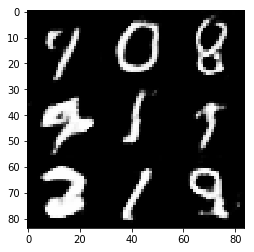

Epoch 2/2... Discriminator Loss: 0.0438... Generator Loss: 5.5569
Epoch 2/2... Discriminator Loss: 0.0730... Generator Loss: 5.2465
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 5.9496
Epoch 2/2... Discriminator Loss: 0.0141... Generator Loss: 5.4258
Epoch 2/2... Discriminator Loss: 0.0144... Generator Loss: 5.7803
Epoch 2/2... Discriminator Loss: 0.0288... Generator Loss: 5.0404
Epoch 2/2... Discriminator Loss: 0.0255... Generator Loss: 5.2957
Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 5.2665
Epoch 2/2... Discriminator Loss: 0.0226... Generator Loss: 4.2164
Epoch 2/2... Discriminator Loss: 0.0313... Generator Loss: 6.5389


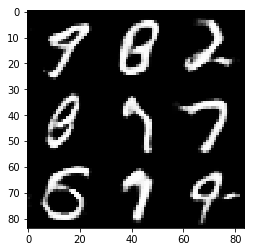

Epoch 2/2... Discriminator Loss: 0.0287... Generator Loss: 6.3778
Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 5.2147
Epoch 2/2... Discriminator Loss: 0.0277... Generator Loss: 2.8834
Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 5.6821
Epoch 2/2... Discriminator Loss: 0.0197... Generator Loss: 5.4322
Epoch 2/2... Discriminator Loss: 0.0209... Generator Loss: 6.1157
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 3.8298
Epoch 2/2... Discriminator Loss: 0.3711... Generator Loss: 4.2271
Epoch 2/2... Discriminator Loss: 0.0957... Generator Loss: 3.5862
Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 3.2249


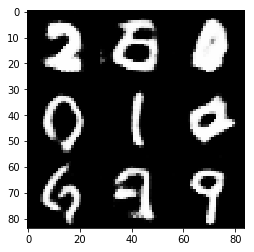

Epoch 2/2... Discriminator Loss: 0.1091... Generator Loss: 3.7197
Epoch 2/2... Discriminator Loss: 0.0612... Generator Loss: 4.2613
Epoch 2/2... Discriminator Loss: 0.0444... Generator Loss: 5.0277
Epoch 2/2... Discriminator Loss: 0.0346... Generator Loss: 4.9895
Epoch 2/2... Discriminator Loss: 0.1196... Generator Loss: 3.5834
Epoch 2/2... Discriminator Loss: 0.0795... Generator Loss: 3.9898
Epoch 2/2... Discriminator Loss: 0.0231... Generator Loss: 6.6946
Epoch 2/2... Discriminator Loss: 0.0122... Generator Loss: 5.8626
Epoch 2/2... Discriminator Loss: 0.0316... Generator Loss: 4.7228
Epoch 2/2... Discriminator Loss: 0.0217... Generator Loss: 6.0331


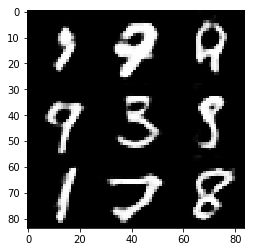

Epoch 2/2... Discriminator Loss: 0.0166... Generator Loss: 4.3856
Epoch 2/2... Discriminator Loss: 0.0220... Generator Loss: 5.0111
Epoch 2/2... Discriminator Loss: 0.0076... Generator Loss: 4.5378
Epoch 2/2... Discriminator Loss: 0.1108... Generator Loss: 4.2570
Epoch 2/2... Discriminator Loss: 0.0192... Generator Loss: 6.2892
Epoch 2/2... Discriminator Loss: 0.0100... Generator Loss: 3.8992
Epoch 2/2... Discriminator Loss: 0.0298... Generator Loss: 4.9112
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 6.0857
Epoch 2/2... Discriminator Loss: 0.0172... Generator Loss: 4.8156
Epoch 2/2... Discriminator Loss: 0.0186... Generator Loss: 5.6429


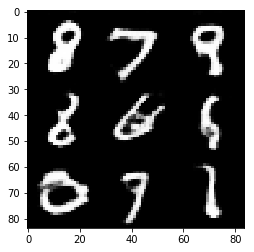

Epoch 2/2... Discriminator Loss: 0.0089... Generator Loss: 6.9461
Epoch 2/2... Discriminator Loss: 0.0392... Generator Loss: 5.9311
Epoch 2/2... Discriminator Loss: 0.0092... Generator Loss: 6.4240
Epoch 2/2... Discriminator Loss: 0.0081... Generator Loss: 6.9754
Epoch 2/2... Discriminator Loss: 0.0077... Generator Loss: 6.8256
Epoch 2/2... Discriminator Loss: 0.0107... Generator Loss: 6.5731
Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.5069
Epoch 2/2... Discriminator Loss: 0.2372... Generator Loss: 3.5572
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 1.3469
Epoch 2/2... Discriminator Loss: 0.1797... Generator Loss: 4.1084


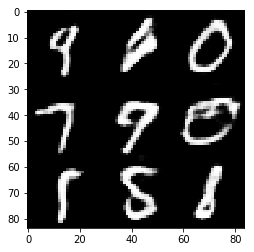

Epoch 2/2... Discriminator Loss: 10.9255... Generator Loss: 16.3919
Epoch 2/2... Discriminator Loss: 0.4863... Generator Loss: 3.2643
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.5755
Epoch 2/2... Discriminator Loss: 0.8392... Generator Loss: 6.0669
Epoch 2/2... Discriminator Loss: 0.1600... Generator Loss: 2.1367
Epoch 2/2... Discriminator Loss: 0.2321... Generator Loss: 5.3599
Epoch 2/2... Discriminator Loss: 0.1398... Generator Loss: 3.5065
Epoch 2/2... Discriminator Loss: 0.0963... Generator Loss: 3.1203
Epoch 2/2... Discriminator Loss: 0.0463... Generator Loss: 3.9251
Epoch 2/2... Discriminator Loss: 0.0567... Generator Loss: 4.1626


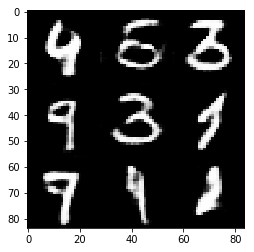

Epoch 2/2... Discriminator Loss: 0.0430... Generator Loss: 4.1259
Epoch 2/2... Discriminator Loss: 0.0524... Generator Loss: 4.3182
Epoch 2/2... Discriminator Loss: 0.0313... Generator Loss: 4.2115
Epoch 2/2... Discriminator Loss: 0.0377... Generator Loss: 4.6013
Epoch 2/2... Discriminator Loss: 0.0242... Generator Loss: 4.4491
Epoch 2/2... Discriminator Loss: 0.0799... Generator Loss: 4.3466
Epoch 2/2... Discriminator Loss: 6.0283... Generator Loss: 11.7686
Epoch 2/2... Discriminator Loss: 0.3218... Generator Loss: 2.2779
Epoch 2/2... Discriminator Loss: 0.2990... Generator Loss: 2.8689
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 2.1067


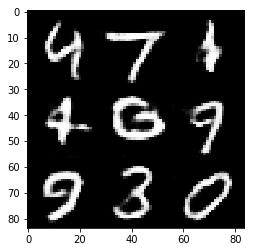

Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 1.3528
Epoch 2/2... Discriminator Loss: 0.1858... Generator Loss: 3.6230
Epoch 2/2... Discriminator Loss: 0.1130... Generator Loss: 2.6638
Epoch 2/2... Discriminator Loss: 0.0712... Generator Loss: 3.4061
Epoch 2/2... Discriminator Loss: 0.1590... Generator Loss: 3.6018
Epoch 2/2... Discriminator Loss: 0.1087... Generator Loss: 3.4146
Epoch 2/2... Discriminator Loss: 0.0914... Generator Loss: 4.0039
Epoch 2/2... Discriminator Loss: 0.0621... Generator Loss: 3.5060
Epoch 2/2... Discriminator Loss: 0.2771... Generator Loss: 2.8349
Epoch 2/2... Discriminator Loss: 0.1133... Generator Loss: 2.6569


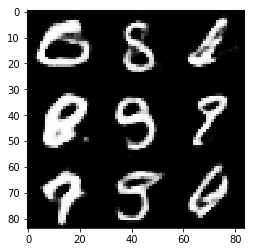

Epoch 2/2... Discriminator Loss: 0.0310... Generator Loss: 4.4836
Epoch 2/2... Discriminator Loss: 0.0461... Generator Loss: 4.3834
Epoch 2/2... Discriminator Loss: 0.1243... Generator Loss: 4.6797
Epoch 2/2... Discriminator Loss: 0.0495... Generator Loss: 4.0824
Epoch 2/2... Discriminator Loss: 0.1383... Generator Loss: 6.6844
Epoch 2/2... Discriminator Loss: 0.0442... Generator Loss: 5.0186
Epoch 2/2... Discriminator Loss: 0.0257... Generator Loss: 5.6592
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 5.2083
Epoch 2/2... Discriminator Loss: 0.0149... Generator Loss: 5.6110
Epoch 2/2... Discriminator Loss: 0.0286... Generator Loss: 5.4643


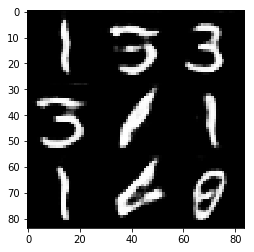

Epoch 2/2... Discriminator Loss: 0.0320... Generator Loss: 3.6350
Epoch 2/2... Discriminator Loss: 0.0164... Generator Loss: 3.9121
Epoch 2/2... Discriminator Loss: 0.1582... Generator Loss: 7.3638
Epoch 2/2... Discriminator Loss: 0.0046... Generator Loss: 5.6048
Epoch 2/2... Discriminator Loss: 0.0183... Generator Loss: 5.7642
Epoch 2/2... Discriminator Loss: 0.0482... Generator Loss: 5.4472
Epoch 2/2... Discriminator Loss: 0.0189... Generator Loss: 6.0598
Epoch 2/2... Discriminator Loss: 0.0421... Generator Loss: 4.5902
Epoch 2/2... Discriminator Loss: 0.0097... Generator Loss: 5.1858
Epoch 2/2... Discriminator Loss: 0.0258... Generator Loss: 5.0198


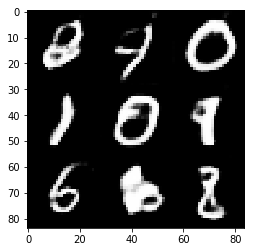

Epoch 2/2... Discriminator Loss: 0.0127... Generator Loss: 6.7558
Epoch 2/2... Discriminator Loss: 0.0111... Generator Loss: 5.0714
Epoch 2/2... Discriminator Loss: 0.0097... Generator Loss: 6.6224
Epoch 2/2... Discriminator Loss: 0.0109... Generator Loss: 5.8663
Epoch 2/2... Discriminator Loss: 0.0242... Generator Loss: 7.1283
Epoch 2/2... Discriminator Loss: 0.0170... Generator Loss: 6.6278
Epoch 2/2... Discriminator Loss: 0.0047... Generator Loss: 5.9970
Epoch 2/2... Discriminator Loss: 0.0036... Generator Loss: 6.3811
Epoch 2/2... Discriminator Loss: 0.0170... Generator Loss: 6.2031
Epoch 2/2... Discriminator Loss: 0.0115... Generator Loss: 6.1462


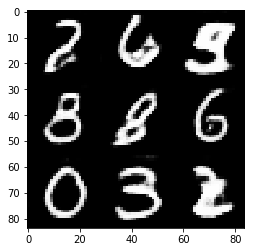

Epoch 2/2... Discriminator Loss: 0.0221... Generator Loss: 6.0003
Epoch 2/2... Discriminator Loss: 0.0077... Generator Loss: 7.7378
Epoch 2/2... Discriminator Loss: 0.0175... Generator Loss: 7.2376
Epoch 2/2... Discriminator Loss: 13.1824... Generator Loss: 0.0000
Epoch 2/2... Discriminator Loss: 0.2419... Generator Loss: 1.9332
Epoch 2/2... Discriminator Loss: 0.2798... Generator Loss: 3.2947
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.3103
Epoch 2/2... Discriminator Loss: 0.1234... Generator Loss: 3.0842
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 8.0497
Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 2.8531


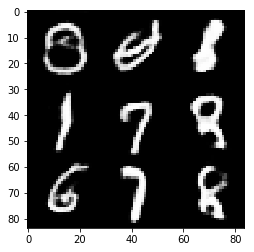

Epoch 2/2... Discriminator Loss: 0.1099... Generator Loss: 4.7168
Epoch 2/2... Discriminator Loss: 1.9483... Generator Loss: 10.0547
Epoch 2/2... Discriminator Loss: 0.1669... Generator Loss: 3.7305
Epoch 2/2... Discriminator Loss: 0.1085... Generator Loss: 3.3604
Epoch 2/2... Discriminator Loss: 0.2983... Generator Loss: 1.9937
Epoch 2/2... Discriminator Loss: 0.2357... Generator Loss: 3.6070
Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 4.8504
Epoch 2/2... Discriminator Loss: 0.1397... Generator Loss: 2.7103
Epoch 2/2... Discriminator Loss: 0.0915... Generator Loss: 3.4204
Epoch 2/2... Discriminator Loss: 0.4874... Generator Loss: 1.6347


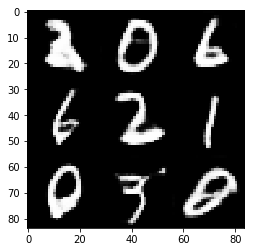

Epoch 2/2... Discriminator Loss: 0.0807... Generator Loss: 4.3534
Epoch 2/2... Discriminator Loss: 0.1233... Generator Loss: 4.7601
Epoch 2/2... Discriminator Loss: 0.1240... Generator Loss: 5.1525
Epoch 2/2... Discriminator Loss: 0.0881... Generator Loss: 3.0413
Epoch 2/2... Discriminator Loss: 0.0727... Generator Loss: 3.5992
Epoch 2/2... Discriminator Loss: 0.0245... Generator Loss: 5.0314
Epoch 2/2... Discriminator Loss: 0.0350... Generator Loss: 4.2190
Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 3.4170
Epoch 2/2... Discriminator Loss: 0.0651... Generator Loss: 3.6421
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 6.5753


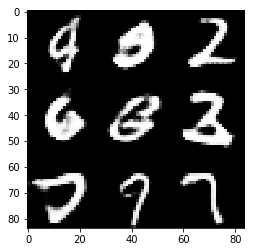

Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.6490
Epoch 2/2... Discriminator Loss: 0.0946... Generator Loss: 2.3924
Epoch 2/2... Discriminator Loss: 0.2340... Generator Loss: 2.7311
Epoch 2/2... Discriminator Loss: 0.0522... Generator Loss: 5.6519
Epoch 2/2... Discriminator Loss: 0.0811... Generator Loss: 2.6643
Epoch 2/2... Discriminator Loss: 0.0305... Generator Loss: 5.6306
Epoch 2/2... Discriminator Loss: 0.0651... Generator Loss: 4.2652
Epoch 2/2... Discriminator Loss: 0.0775... Generator Loss: 3.8107
Epoch 2/2... Discriminator Loss: 0.0389... Generator Loss: 4.8113
Epoch 2/2... Discriminator Loss: 0.0635... Generator Loss: 3.5971


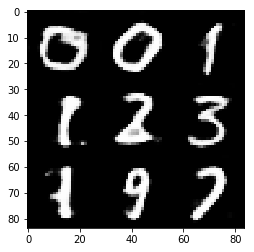

Epoch 2/2... Discriminator Loss: 0.0491... Generator Loss: 5.0526
Epoch 2/2... Discriminator Loss: 0.0168... Generator Loss: 4.9671
Epoch 2/2... Discriminator Loss: 0.0334... Generator Loss: 5.5631
Epoch 2/2... Discriminator Loss: 0.0089... Generator Loss: 6.8552
Epoch 2/2... Discriminator Loss: 0.0134... Generator Loss: 5.7282


In [101]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1592... Generator Loss: 2.0525
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 6.9031
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 2.7627
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 5.6309
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 0.2871... Generator Loss: 15.6199
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 6.9364
Epoch 1/1... Discriminator Loss: 0.0603... Generator Loss: 3.8452
Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 2.3291


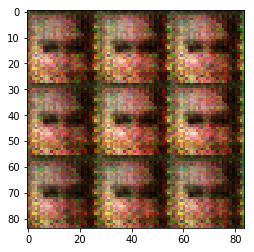

Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 5.8482
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 2.3365
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 3.8011
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 8.3138
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 3.3895
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 3.7851
Epoch 1/1... Discriminator Loss: 0.3083... Generator Loss: 13.5862
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.2450... Generator Loss: 4.1695
Epoch 1/1... Discriminator Loss: 0.1072... Generator Loss: 3.3496


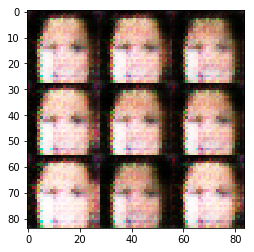

Epoch 1/1... Discriminator Loss: 0.0921... Generator Loss: 4.0930
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 3.4182
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 0.0535... Generator Loss: 4.4133
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 3.4203
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 4.8247
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.2927
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 2.6105
Epoch 1/1... Discriminator Loss: 0.2146... Generator Loss: 2.7835


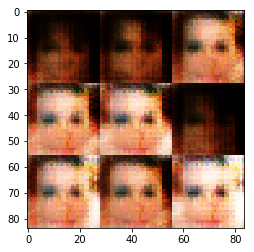

Epoch 1/1... Discriminator Loss: 0.0792... Generator Loss: 3.1473
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 4.1680
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 4.0840
Epoch 1/1... Discriminator Loss: 0.1132... Generator Loss: 3.6778
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 2.0390
Epoch 1/1... Discriminator Loss: 0.2438... Generator Loss: 6.7857
Epoch 1/1... Discriminator Loss: 0.1488... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 2.7297


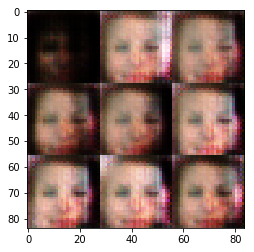

Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 2.4668
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 5.9209
Epoch 1/1... Discriminator Loss: 2.4548... Generator Loss: 8.8056
Epoch 1/1... Discriminator Loss: 0.2869... Generator Loss: 3.2328
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 2.9942
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 1.9932
Epoch 1/1... Discriminator Loss: 0.3607... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 2.4678... Generator Loss: 7.4801
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.0920


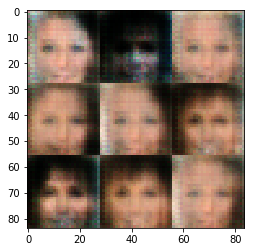

Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.2100... Generator Loss: 2.7758
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 4.2470
Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 2.6559
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 3.7578
Epoch 1/1... Discriminator Loss: 0.2688... Generator Loss: 3.4935
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 3.0871
Epoch 1/1... Discriminator Loss: 2.8583... Generator Loss: 0.2673
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 0.2627... Generator Loss: 2.1723


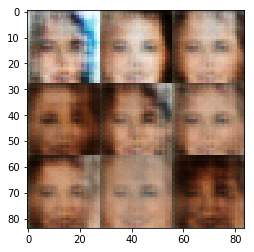

Epoch 1/1... Discriminator Loss: 0.2519... Generator Loss: 2.2876
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 6.2075
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 5.6454
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 0.2187... Generator Loss: 4.8899
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 2.9676
Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 2.9505
Epoch 1/1... Discriminator Loss: 0.2242... Generator Loss: 3.3265
Epoch 1/1... Discriminator Loss: 0.3215... Generator Loss: 1.4291


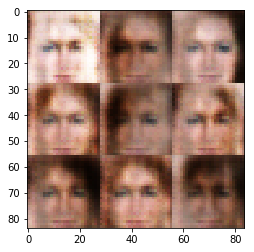

Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 2.9252
Epoch 1/1... Discriminator Loss: 0.3054... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 1.4837
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 0.2996... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 4.8827
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 2.3375
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 2.9689


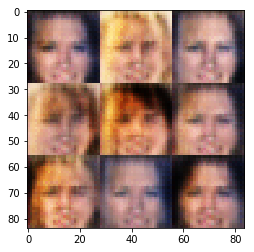

Epoch 1/1... Discriminator Loss: 0.2561... Generator Loss: 2.4348
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 0.2821... Generator Loss: 2.5012
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 5.6785
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 2.8836
Epoch 1/1... Discriminator Loss: 0.6782... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 3.3417


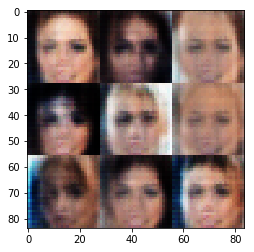

Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 1.6256
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 5.0606
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 2.5122
Epoch 1/1... Discriminator Loss: 0.2094... Generator Loss: 2.6600
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 1.6819


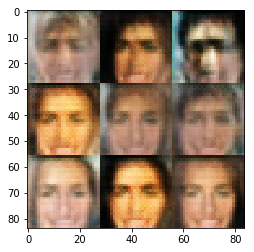

Epoch 1/1... Discriminator Loss: 0.3189... Generator Loss: 2.1945
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 3.0362
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 2.6943
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 5.0140
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.4042


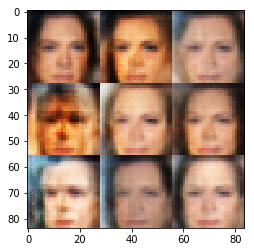

Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 1.8121
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 3.0326
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 2.0284
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.2655... Generator Loss: 2.6603
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 1.8278
Epoch 1/1... Discriminator Loss: 0.3085... Generator Loss: 2.6724


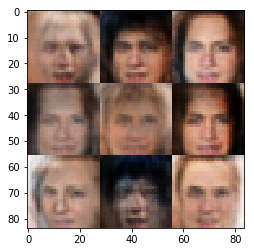

Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 3.9024
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 0.2337... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 0.1989... Generator Loss: 2.8376
Epoch 1/1... Discriminator Loss: 0.2367... Generator Loss: 2.9850
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 1.4806


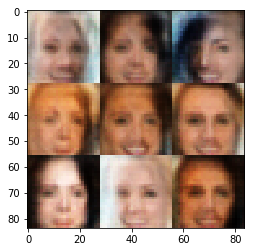

Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 5.6124
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 3.0252
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 2.6555
Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.3105... Generator Loss: 3.5103


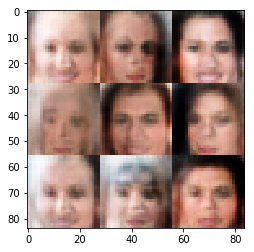

Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 2.0169
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 3.0203
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 2.5171
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 3.3948
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 2.6619
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 2.0043
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 2.9984
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.2788
Epoch 1/1... Discriminator Loss: 0.1264... Generator Loss: 2.8113


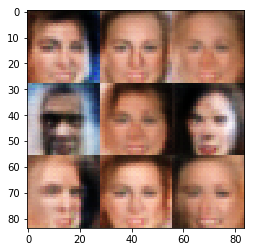

Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 2.9934
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 4.8703
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 2.6890
Epoch 1/1... Discriminator Loss: 0.3215... Generator Loss: 2.2136
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 1.5628
Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 3.3636
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 3.3580
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.2396... Generator Loss: 2.4690


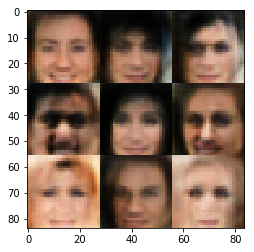

Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 4.7910
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 4.4071
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.1435
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 4.0477
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.2124... Generator Loss: 2.4288
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 5.2545
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 6.4409
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 2.3444
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 5.0787


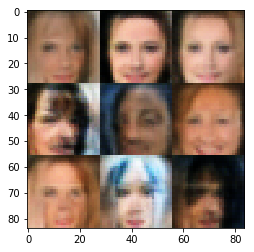

Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 0.2287... Generator Loss: 3.0340
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 0.3040... Generator Loss: 2.6254
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 1.7876
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 0.2997... Generator Loss: 1.7703
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 2.6306
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 2.5590
Epoch 1/1... Discriminator Loss: 0.3199... Generator Loss: 2.7064


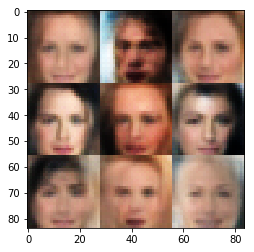

Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 2.8131
Epoch 1/1... Discriminator Loss: 0.2775... Generator Loss: 2.2624
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 3.3402
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 2.4930
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 2.1793
Epoch 1/1... Discriminator Loss: 0.2252... Generator Loss: 4.0755
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 3.6933
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.2421


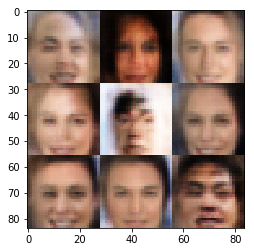

Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 1.8469
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 2.5825
Epoch 1/1... Discriminator Loss: 0.2416... Generator Loss: 1.6510
Epoch 1/1... Discriminator Loss: 2.4745... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 0.2222... Generator Loss: 2.4664
Epoch 1/1... Discriminator Loss: 0.2192... Generator Loss: 2.3342
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 2.8476
Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 3.4306
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 2.9059
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 1.8437


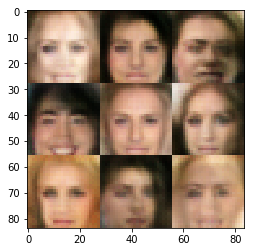

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 1.7877
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 5.4751
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 2.3764
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 3.0997
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 2.2605
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.3039... Generator Loss: 2.0608


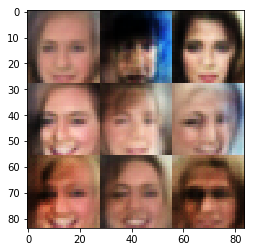

Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 3.0779
Epoch 1/1... Discriminator Loss: 0.2799... Generator Loss: 3.9410
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 3.4533
Epoch 1/1... Discriminator Loss: 0.3048... Generator Loss: 2.2446
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 0.2069... Generator Loss: 2.7870
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.1004
Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 2.3624


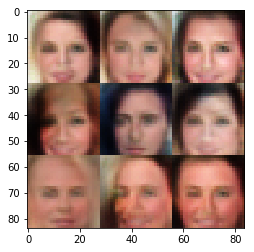

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 4.2077
Epoch 1/1... Discriminator Loss: 0.2000... Generator Loss: 2.9819
Epoch 1/1... Discriminator Loss: 0.2886... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 0.3688... Generator Loss: 2.1762
Epoch 1/1... Discriminator Loss: 0.1472... Generator Loss: 3.3139
Epoch 1/1... Discriminator Loss: 0.3087... Generator Loss: 2.8178
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 5.2150


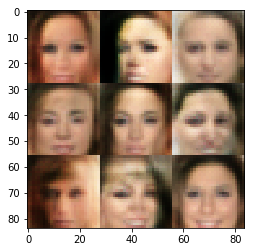

Epoch 1/1... Discriminator Loss: 0.2138... Generator Loss: 3.6904
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.3340
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 3.9815
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 0.1575... Generator Loss: 4.0146
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 4.3426
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 4.0140
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.1340
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 2.0998
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 1.3350


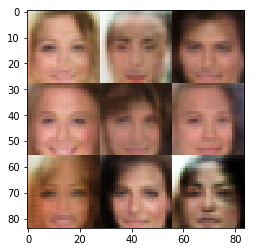

Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 2.4586
Epoch 1/1... Discriminator Loss: 0.1683... Generator Loss: 2.5753
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 4.5990
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 3.9521
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 2.6540
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 0.1257... Generator Loss: 4.2494
Epoch 1/1... Discriminator Loss: 0.1933... Generator Loss: 2.0614
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 3.7043


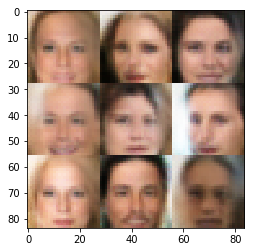

Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 3.6549
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 2.5450
Epoch 1/1... Discriminator Loss: 2.2155... Generator Loss: 6.6841
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 3.5781
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 2.2502
Epoch 1/1... Discriminator Loss: 0.2344... Generator Loss: 3.4563


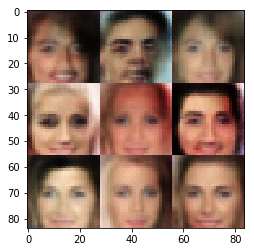

Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 2.3439
Epoch 1/1... Discriminator Loss: 0.1604... Generator Loss: 2.3375
Epoch 1/1... Discriminator Loss: 0.2696... Generator Loss: 2.4903
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 3.2695
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 2.2001... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.2904... Generator Loss: 1.9322
Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 2.5555
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 2.5564


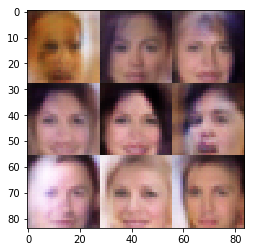

Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.7783
Epoch 1/1... Discriminator Loss: 0.1772... Generator Loss: 3.5772
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 1.8209
Epoch 1/1... Discriminator Loss: 0.3113... Generator Loss: 2.1648
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 1.6455
Epoch 1/1... Discriminator Loss: 0.2262... Generator Loss: 3.1193
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 2.1980
Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 3.9946


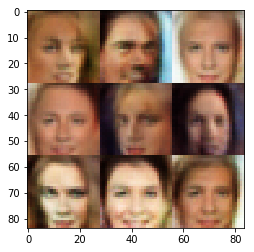

Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 3.8945
Epoch 1/1... Discriminator Loss: 0.2005... Generator Loss: 2.5948
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 2.4558
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 3.1584
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 0.2503... Generator Loss: 3.1442
Epoch 1/1... Discriminator Loss: 0.1309... Generator Loss: 3.5589
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.0213


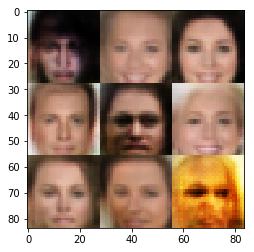

Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 3.6950
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 2.1079
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 3.6356
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 2.6990
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 4.6880
Epoch 1/1... Discriminator Loss: 0.3124... Generator Loss: 2.9783
Epoch 1/1... Discriminator Loss: 0.1757... Generator Loss: 2.7182
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 0.4291


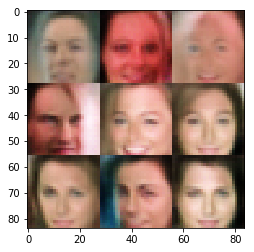

Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.8641
Epoch 1/1... Discriminator Loss: 2.7286... Generator Loss: 9.6924
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 2.0975
Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 3.1898
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 2.8918
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 0.1343... Generator Loss: 2.8388
Epoch 1/1... Discriminator Loss: 0.2407... Generator Loss: 2.8182
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 3.2687


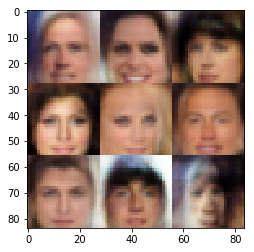

Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 2.6969
Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 2.9136
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 1.5369
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 3.5045
Epoch 1/1... Discriminator Loss: 0.2772... Generator Loss: 3.4897
Epoch 1/1... Discriminator Loss: 0.2118... Generator Loss: 2.1410
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 6.0535


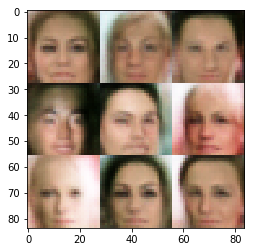

Epoch 1/1... Discriminator Loss: 0.1942... Generator Loss: 3.5189
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 0.0855... Generator Loss: 3.2480
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 2.3267
Epoch 1/1... Discriminator Loss: 2.4748... Generator Loss: 0.3816
Epoch 1/1... Discriminator Loss: 0.2457... Generator Loss: 2.2192
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 2.7430
Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 2.1735
Epoch 1/1... Discriminator Loss: 0.1712... Generator Loss: 2.9619
Epoch 1/1... Discriminator Loss: 0.2303... Generator Loss: 1.7368


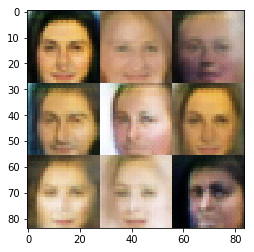

Epoch 1/1... Discriminator Loss: 0.1455... Generator Loss: 2.6845
Epoch 1/1... Discriminator Loss: 0.2194... Generator Loss: 5.2831
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 1.8380
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 3.6634
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.2387
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 2.0732
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 4.6157
Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 4.0392
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 3.0270
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.5510


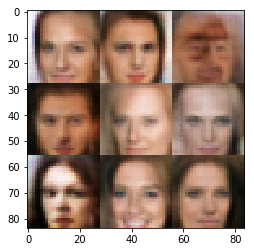

Epoch 1/1... Discriminator Loss: 0.2540... Generator Loss: 2.3650
Epoch 1/1... Discriminator Loss: 0.1376... Generator Loss: 4.0084
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 2.8920
Epoch 1/1... Discriminator Loss: 0.0396... Generator Loss: 3.3546
Epoch 1/1... Discriminator Loss: 0.2871... Generator Loss: 4.6538
Epoch 1/1... Discriminator Loss: 0.1111... Generator Loss: 3.0532
Epoch 1/1... Discriminator Loss: 0.2843... Generator Loss: 5.1818
Epoch 1/1... Discriminator Loss: 0.1766... Generator Loss: 3.4223
Epoch 1/1... Discriminator Loss: 0.1265... Generator Loss: 3.7395
Epoch 1/1... Discriminator Loss: 0.1646... Generator Loss: 3.1996


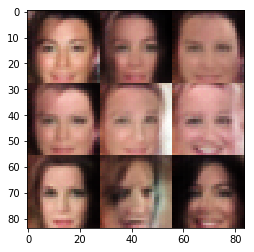

Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 2.4652
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 4.2593
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 3.8571
Epoch 1/1... Discriminator Loss: 0.0668... Generator Loss: 3.8230
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 2.5704
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 3.7084
Epoch 1/1... Discriminator Loss: 0.2354... Generator Loss: 3.1457
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 3.2347
Epoch 1/1... Discriminator Loss: 0.2610... Generator Loss: 1.8324
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 2.9611


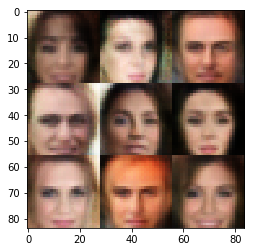

Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 4.2635
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 6.8689
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 1.5764
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.9365
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 4.1069
Epoch 1/1... Discriminator Loss: 0.0842... Generator Loss: 3.5506
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 0.1768... Generator Loss: 2.3855
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.1464... Generator Loss: 3.9320


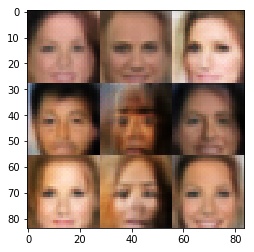

Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 3.7489
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 4.0397
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 6.8997
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 3.0789
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 3.0975
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 2.7742
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 1.2752
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 3.3646
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 2.7899
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 3.5992


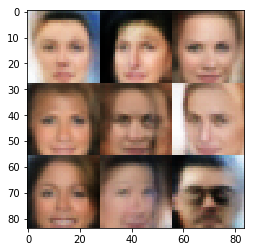

Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 2.7978
Epoch 1/1... Discriminator Loss: 0.1279... Generator Loss: 3.0998
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 6.7937
Epoch 1/1... Discriminator Loss: 0.3193... Generator Loss: 2.6908
Epoch 1/1... Discriminator Loss: 0.2148... Generator Loss: 3.1621
Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 3.6717
Epoch 1/1... Discriminator Loss: 0.0935... Generator Loss: 4.1081
Epoch 1/1... Discriminator Loss: 0.1712... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 2.0357


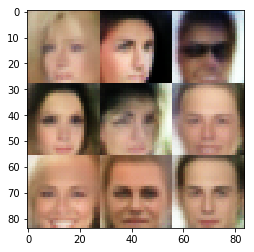

Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 3.3509
Epoch 1/1... Discriminator Loss: 3.1001... Generator Loss: 8.2728
Epoch 1/1... Discriminator Loss: 0.2336... Generator Loss: 2.6457
Epoch 1/1... Discriminator Loss: 0.1192... Generator Loss: 3.7424
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.8190
Epoch 1/1... Discriminator Loss: 0.2634... Generator Loss: 3.9806
Epoch 1/1... Discriminator Loss: 0.1342... Generator Loss: 3.9583
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 2.9948
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 3.6598
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 2.4826


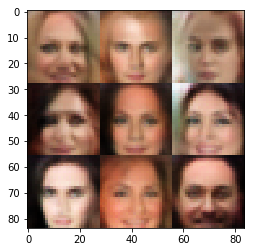

Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 3.0138
Epoch 1/1... Discriminator Loss: 0.1976... Generator Loss: 3.2812
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.3180... Generator Loss: 4.5835
Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 3.2683
Epoch 1/1... Discriminator Loss: 0.1513... Generator Loss: 3.2609
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.2455
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 2.8194
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 3.1941
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 3.0442


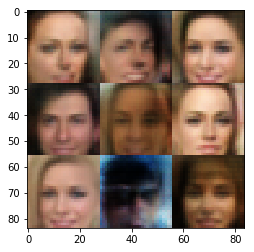

Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 3.2551
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 3.9508
Epoch 1/1... Discriminator Loss: 0.1510... Generator Loss: 3.2351
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 8.2936
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 2.3339
Epoch 1/1... Discriminator Loss: 0.2489... Generator Loss: 3.6924
Epoch 1/1... Discriminator Loss: 0.6128... Generator Loss: 5.5995
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 2.7629
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 2.2664
Epoch 1/1... Discriminator Loss: 0.1452... Generator Loss: 3.7167


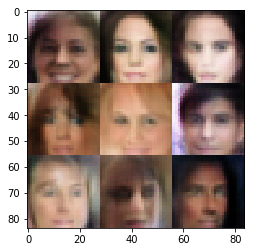

Epoch 1/1... Discriminator Loss: 0.1095... Generator Loss: 2.8618
Epoch 1/1... Discriminator Loss: 0.2651... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 0.2113... Generator Loss: 2.5714
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 2.9003
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 3.2597
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 2.6315
Epoch 1/1... Discriminator Loss: 0.1287... Generator Loss: 3.1859
Epoch 1/1... Discriminator Loss: 0.0645... Generator Loss: 3.6062
Epoch 1/1... Discriminator Loss: 0.2567... Generator Loss: 4.1982


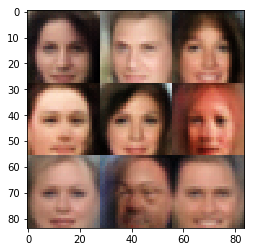

Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 4.9438
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 2.4399
Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 2.8055
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 5.5713
Epoch 1/1... Discriminator Loss: 0.1976... Generator Loss: 2.5972
Epoch 1/1... Discriminator Loss: 0.2063... Generator Loss: 5.7629
Epoch 1/1... Discriminator Loss: 0.1137... Generator Loss: 3.5740
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 5.5129
Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 2.6038


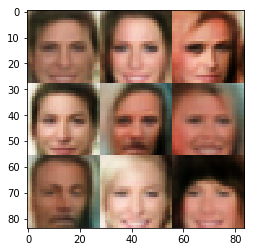

Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 2.7511
Epoch 1/1... Discriminator Loss: 0.0972... Generator Loss: 3.5507
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.8385... Generator Loss: 6.5708
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.1169... Generator Loss: 3.5729
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 1.5334
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 3.8800
Epoch 1/1... Discriminator Loss: 0.1743... Generator Loss: 3.4947
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 2.9516


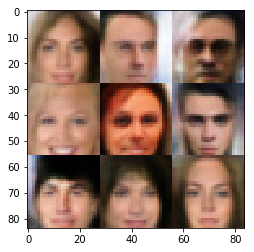

Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 2.7615
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 3.8400
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 2.7488
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 4.2280
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 2.9114
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 3.5917
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 2.7885
Epoch 1/1... Discriminator Loss: 0.1770... Generator Loss: 3.7923
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 3.0308


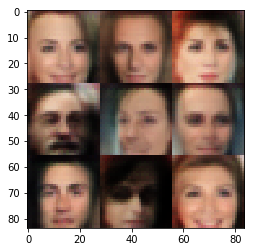

Epoch 1/1... Discriminator Loss: 0.1017... Generator Loss: 2.4974
Epoch 1/1... Discriminator Loss: 0.0973... Generator Loss: 3.8252
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 2.8225
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.6552
Epoch 1/1... Discriminator Loss: 0.0947... Generator Loss: 2.5681
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 2.4533
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 3.7486
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.8150
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 3.5784


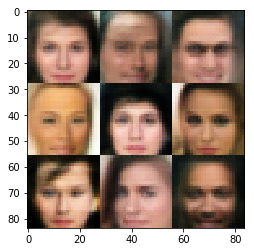

Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 2.2989
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 4.0353
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 3.1893
Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 3.5466
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 3.6639
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.8177
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 7.0514
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 2.0633
Epoch 1/1... Discriminator Loss: 0.1675... Generator Loss: 2.6977


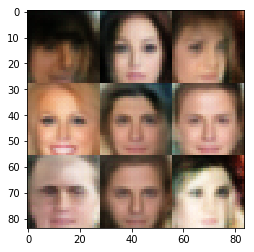

Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 3.6164
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 0.1272... Generator Loss: 2.9271
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 2.8081
Epoch 1/1... Discriminator Loss: 0.2043... Generator Loss: 2.6333
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 4.8353
Epoch 1/1... Discriminator Loss: 0.1647... Generator Loss: 3.8025
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 5.0473
Epoch 1/1... Discriminator Loss: 0.1076... Generator Loss: 3.2944
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 5.7577


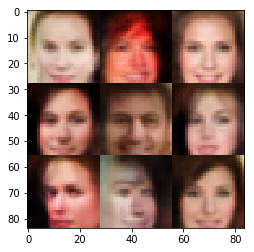

Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 2.4046
Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 2.9927
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 3.5593
Epoch 1/1... Discriminator Loss: 0.1023... Generator Loss: 2.8645
Epoch 1/1... Discriminator Loss: 0.1291... Generator Loss: 2.5598
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 5.1697
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 4.2683
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 7.1390
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 5.8366
Epoch 1/1... Discriminator Loss: 0.1993... Generator Loss: 3.2956


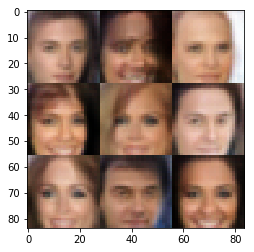

Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 2.4156
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 4.5137
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 3.7652
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 2.9122
Epoch 1/1... Discriminator Loss: 0.1524... Generator Loss: 2.5896
Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 3.8331
Epoch 1/1... Discriminator Loss: 0.1202... Generator Loss: 3.1437
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 4.6067
Epoch 1/1... Discriminator Loss: 1.8735... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.2804


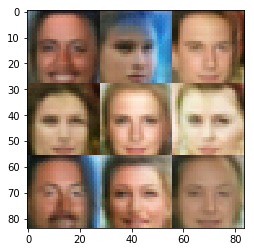

Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 3.5091
Epoch 1/1... Discriminator Loss: 0.1371... Generator Loss: 3.0288
Epoch 1/1... Discriminator Loss: 0.1472... Generator Loss: 2.9191
Epoch 1/1... Discriminator Loss: 0.1219... Generator Loss: 2.8176
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 7.2421
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 4.3414
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 2.2337
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 2.8805
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.2329
Epoch 1/1... Discriminator Loss: 0.4923... Generator Loss: 5.1032


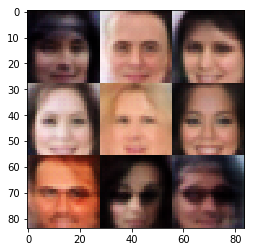

Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 4.1901
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 4.0247
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 2.8101
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.0853... Generator Loss: 3.3071
Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 3.7042
Epoch 1/1... Discriminator Loss: 0.0711... Generator Loss: 5.1351
Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 4.9781
Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 5.0804


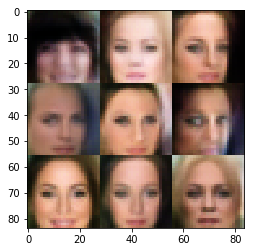

Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 3.7545
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 3.4932
Epoch 1/1... Discriminator Loss: 0.1561... Generator Loss: 3.7518
Epoch 1/1... Discriminator Loss: 0.1502... Generator Loss: 5.2136
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 2.1420
Epoch 1/1... Discriminator Loss: 0.1287... Generator Loss: 3.2804
Epoch 1/1... Discriminator Loss: 0.0983... Generator Loss: 3.3294
Epoch 1/1... Discriminator Loss: 0.2297... Generator Loss: 2.8304
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 3.4899


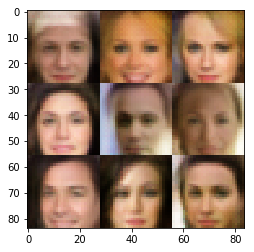

Epoch 1/1... Discriminator Loss: 0.1128... Generator Loss: 3.6884
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 3.4143
Epoch 1/1... Discriminator Loss: 0.1627... Generator Loss: 3.3721
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 4.9817
Epoch 1/1... Discriminator Loss: 0.1122... Generator Loss: 4.6518
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 5.3145
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 4.9138
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 4.5235
Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 3.1914


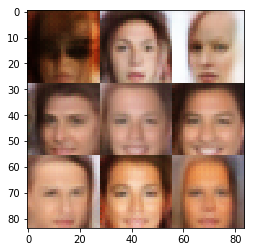

Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 4.5247
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 4.3006
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 0.1512... Generator Loss: 2.9509
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 2.9356
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 3.4271
Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 3.9860
Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 4.3404
Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 3.5328
Epoch 1/1... Discriminator Loss: 0.0948... Generator Loss: 3.2295


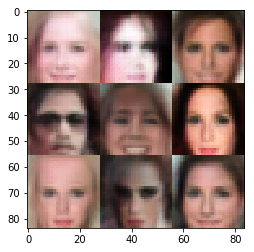

Epoch 1/1... Discriminator Loss: 0.2359... Generator Loss: 5.1566
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.5932
Epoch 1/1... Discriminator Loss: 0.1113... Generator Loss: 3.6912
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 3.6914
Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 3.3564
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 4.0471
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 5.4748
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 6.0868
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 2.3809


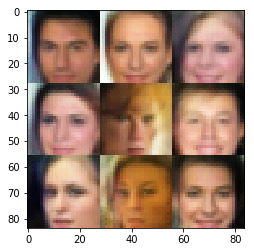

Epoch 1/1... Discriminator Loss: 0.0868... Generator Loss: 4.5119
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 4.2070
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 3.6031
Epoch 1/1... Discriminator Loss: 0.1500... Generator Loss: 3.3694
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.3507
Epoch 1/1... Discriminator Loss: 3.2467... Generator Loss: 0.1225
Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 3.5556
Epoch 1/1... Discriminator Loss: 0.2072... Generator Loss: 2.6005
Epoch 1/1... Discriminator Loss: 0.1429... Generator Loss: 4.3377
Epoch 1/1... Discriminator Loss: 0.2418... Generator Loss: 3.3720


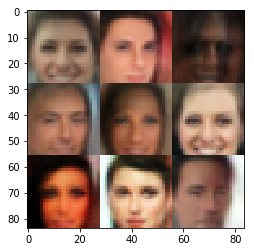

Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 2.6505
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 4.2532
Epoch 1/1... Discriminator Loss: 0.0777... Generator Loss: 5.4822
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 3.4896
Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 4.8869
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 2.5941
Epoch 1/1... Discriminator Loss: 0.1333... Generator Loss: 3.0014
Epoch 1/1... Discriminator Loss: 0.0753... Generator Loss: 3.9846
Epoch 1/1... Discriminator Loss: 0.1452... Generator Loss: 3.0014
Epoch 1/1... Discriminator Loss: 2.4983... Generator Loss: 0.2281


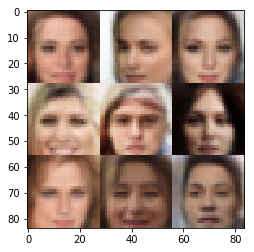

Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 2.5507
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.1417
Epoch 1/1... Discriminator Loss: 0.1220... Generator Loss: 3.3095
Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 3.6359
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 3.6770
Epoch 1/1... Discriminator Loss: 0.1592... Generator Loss: 3.2862
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 3.8738
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 4.2921
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 6.1566


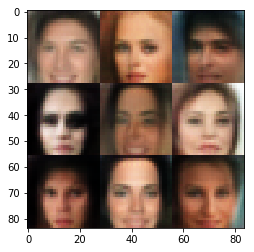

Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.2339
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 2.0975
Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 0.2253... Generator Loss: 2.1549
Epoch 1/1... Discriminator Loss: 0.2527... Generator Loss: 2.5882
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.6372
Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 5.2981
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 3.8821
Epoch 1/1... Discriminator Loss: 0.0666... Generator Loss: 3.8851
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 3.3806


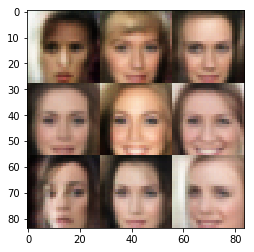

Epoch 1/1... Discriminator Loss: 0.1123... Generator Loss: 3.9932
Epoch 1/1... Discriminator Loss: 0.0642... Generator Loss: 3.5906
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 4.1295
Epoch 1/1... Discriminator Loss: 0.1938... Generator Loss: 3.0444
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 4.9182
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 5.4280
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 7.5235
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.4712
Epoch 1/1... Discriminator Loss: 0.1230... Generator Loss: 4.3658


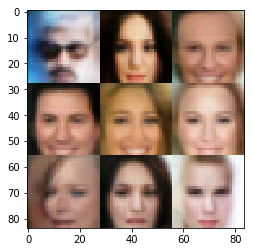

Epoch 1/1... Discriminator Loss: 0.1432... Generator Loss: 3.7094
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 4.5341
Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 3.3115
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 8.6787
Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 3.0134
Epoch 1/1... Discriminator Loss: 0.1275... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 3.4201
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 5.8930
Epoch 1/1... Discriminator Loss: 0.1397... Generator Loss: 2.3485
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 4.5126


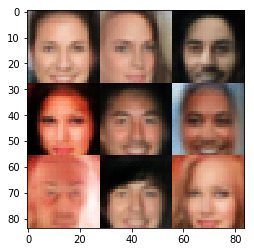

Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 2.8379
Epoch 1/1... Discriminator Loss: 0.0426... Generator Loss: 4.2792
Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 4.8629
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 5.5238
Epoch 1/1... Discriminator Loss: 0.0490... Generator Loss: 4.0116
Epoch 1/1... Discriminator Loss: 0.1684... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 0.3165... Generator Loss: 1.7447
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 6.4489
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 5.3801
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 3.8672


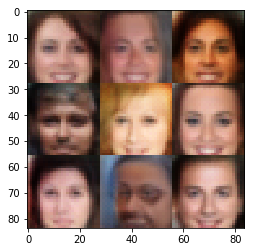

Epoch 1/1... Discriminator Loss: 1.8781... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 0.2505... Generator Loss: 2.1363
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 3.4652
Epoch 1/1... Discriminator Loss: 0.2138... Generator Loss: 2.5814
Epoch 1/1... Discriminator Loss: 0.1244... Generator Loss: 3.3080
Epoch 1/1... Discriminator Loss: 0.0517... Generator Loss: 4.0803
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 3.4076
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 3.1689
Epoch 1/1... Discriminator Loss: 0.2489... Generator Loss: 2.5023


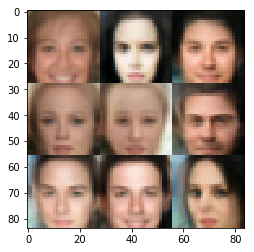

Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 5.2508
Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 4.1507
Epoch 1/1... Discriminator Loss: 6.8351... Generator Loss: 11.0249
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 1.7249
Epoch 1/1... Discriminator Loss: 0.1597... Generator Loss: 3.8330
Epoch 1/1... Discriminator Loss: 0.2345... Generator Loss: 3.2681
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 2.8703
Epoch 1/1... Discriminator Loss: 0.0854... Generator Loss: 3.1885
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 3.0191


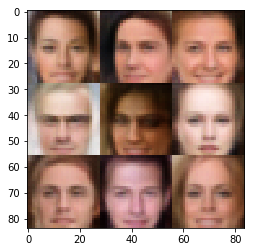

Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 6.1030
Epoch 1/1... Discriminator Loss: 0.1619... Generator Loss: 3.0476
Epoch 1/1... Discriminator Loss: 0.1759... Generator Loss: 2.9480
Epoch 1/1... Discriminator Loss: 0.0291... Generator Loss: 4.2531
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 2.6071
Epoch 1/1... Discriminator Loss: 0.4147... Generator Loss: 5.0609
Epoch 1/1... Discriminator Loss: 0.0849... Generator Loss: 4.6197
Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 3.5912
Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 4.7534
Epoch 1/1... Discriminator Loss: 0.0773... Generator Loss: 4.8768


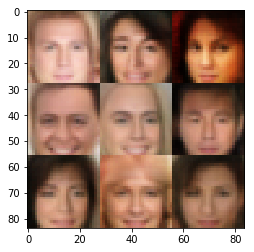

Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 5.3881
Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 4.4401
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 3.6507
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 4.1600
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 2.8117
Epoch 1/1... Discriminator Loss: 0.1233... Generator Loss: 3.8467
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 4.1061
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 4.9854
Epoch 1/1... Discriminator Loss: 0.0888... Generator Loss: 3.2000
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 4.2911


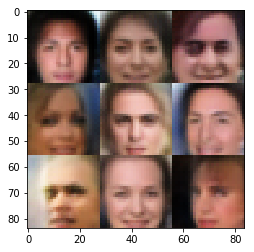

Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.1602... Generator Loss: 3.2423
Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 3.9069
Epoch 1/1... Discriminator Loss: 0.0911... Generator Loss: 3.7320
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 4.2325
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 1.8805
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 4.1017
Epoch 1/1... Discriminator Loss: 0.1486... Generator Loss: 3.0733
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.3961
Epoch 1/1... Discriminator Loss: 0.2645... Generator Loss: 2.2879


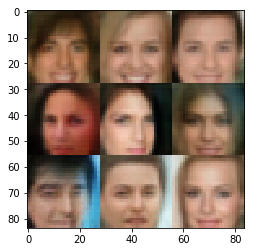

Epoch 1/1... Discriminator Loss: 2.7828... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 1.9723
Epoch 1/1... Discriminator Loss: 0.1022... Generator Loss: 2.9795
Epoch 1/1... Discriminator Loss: 0.1078... Generator Loss: 4.6288
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.2103
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 0.1627... Generator Loss: 3.2111
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.0986
Epoch 1/1... Discriminator Loss: 0.0897... Generator Loss: 3.5158


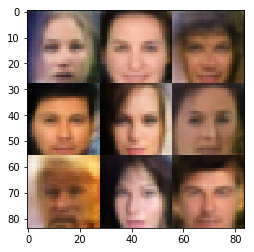

Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 4.1253
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 4.3812
Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 5.0811
Epoch 1/1... Discriminator Loss: 0.2446... Generator Loss: 3.3842
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.8123
Epoch 1/1... Discriminator Loss: 0.1093... Generator Loss: 5.1774
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 4.2152
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 3.0851
Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 4.1919
Epoch 1/1... Discriminator Loss: 0.1101... Generator Loss: 2.9314


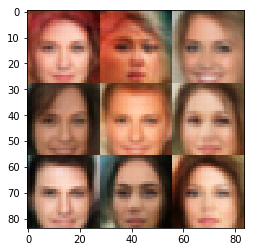

Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 3.9139
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 2.2398
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 3.6549
Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 0.0551... Generator Loss: 3.2029
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 5.3660
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.9109
Epoch 1/1... Discriminator Loss: 0.0912... Generator Loss: 4.0236
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 5.6232
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 3.8983


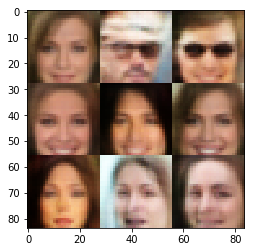

Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 3.9306
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 5.5320
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 7.0791
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 2.7698
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 4.2715
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 3.1155
Epoch 1/1... Discriminator Loss: 0.0972... Generator Loss: 3.9541
Epoch 1/1... Discriminator Loss: 0.0859... Generator Loss: 3.7457
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 3.7926
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 5.0260


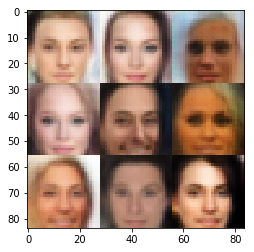

Epoch 1/1... Discriminator Loss: 0.0773... Generator Loss: 3.2501
Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 5.6849
Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 3.5604
Epoch 1/1... Discriminator Loss: 3.6592... Generator Loss: 8.0558
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.4356
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 2.9110
Epoch 1/1... Discriminator Loss: 0.1030... Generator Loss: 5.0198
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 3.2874
Epoch 1/1... Discriminator Loss: 0.1353... Generator Loss: 4.9908
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 4.0130


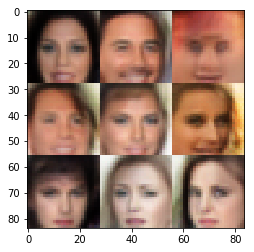

Epoch 1/1... Discriminator Loss: 0.0815... Generator Loss: 4.1833
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 5.8686
Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 3.9115
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 4.6867
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 3.1742
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 3.4009
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 4.3590
Epoch 1/1... Discriminator Loss: 0.0866... Generator Loss: 4.7176
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 2.2222
Epoch 1/1... Discriminator Loss: 0.0561... Generator Loss: 4.6671


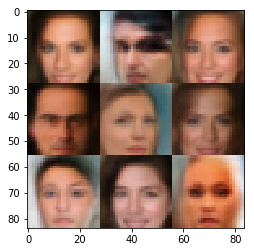

Epoch 1/1... Discriminator Loss: 0.0239... Generator Loss: 5.2808
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.5616
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 4.5146
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 4.7899
Epoch 1/1... Discriminator Loss: 0.1362... Generator Loss: 4.1596
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 0.1588... Generator Loss: 3.9014
Epoch 1/1... Discriminator Loss: 0.1614... Generator Loss: 3.4571
Epoch 1/1... Discriminator Loss: 0.1037... Generator Loss: 5.6340


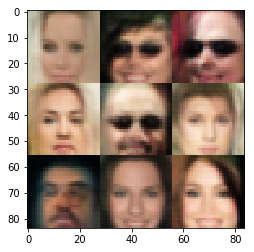

Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 4.6756
Epoch 1/1... Discriminator Loss: 0.0750... Generator Loss: 3.7452
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.7535
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 3.3716
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 4.0313
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.0058
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 2.3971
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 3.6680
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 2.2625
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.8424


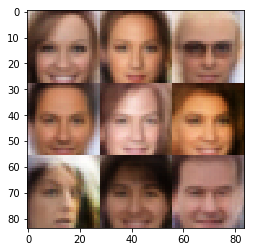

Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 2.6626
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 3.2041
Epoch 1/1... Discriminator Loss: 0.0555... Generator Loss: 4.2037
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 2.5584
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4211
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 2.5457
Epoch 1/1... Discriminator Loss: 0.3017... Generator Loss: 2.2632
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 3.1709
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 4.8060
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 4.4748


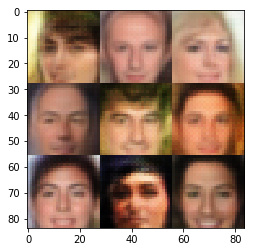

Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.9734
Epoch 1/1... Discriminator Loss: 0.0774... Generator Loss: 2.8601
Epoch 1/1... Discriminator Loss: 0.1716... Generator Loss: 4.9239
Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 3.8019
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 3.0394
Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 4.7105
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.1181... Generator Loss: 3.2909
Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 3.9081
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 2.2937


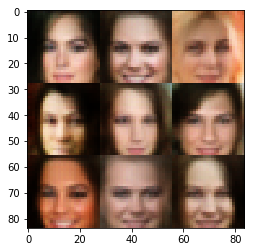

Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 3.1440
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 5.2837
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 4.3783
Epoch 1/1... Discriminator Loss: 0.3252... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 0.0463... Generator Loss: 3.7600
Epoch 1/1... Discriminator Loss: 0.2304... Generator Loss: 6.1073
Epoch 1/1... Discriminator Loss: 0.2031... Generator Loss: 1.5833
Epoch 1/1... Discriminator Loss: 0.0364... Generator Loss: 5.6807
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 4.4977
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 4.4656


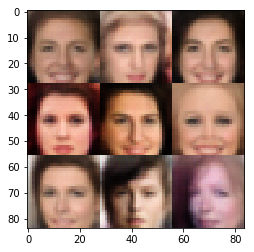

Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 4.7021
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 4.8078
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 5.8753
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 4.2670
Epoch 1/1... Discriminator Loss: 2.2982... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 0.2289... Generator Loss: 2.2388
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.5385
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 4.6097
Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 3.6163
Epoch 1/1... Discriminator Loss: 0.1363... Generator Loss: 4.5735


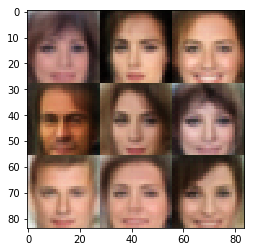

Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 4.1526
Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 4.3918
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 5.5966
Epoch 1/1... Discriminator Loss: 0.0598... Generator Loss: 3.9484
Epoch 1/1... Discriminator Loss: 0.0695... Generator Loss: 4.7686
Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 3.5450
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 4.0807
Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 4.3522
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 5.2682
Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 5.2971


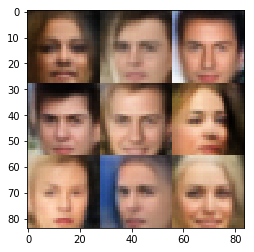

Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 4.7342
Epoch 1/1... Discriminator Loss: 0.1124... Generator Loss: 4.6692
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 3.2560
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 3.4671
Epoch 1/1... Discriminator Loss: 0.2312... Generator Loss: 2.8255
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 3.9432
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 6.6933
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 4.8387
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 4.1797
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.0474


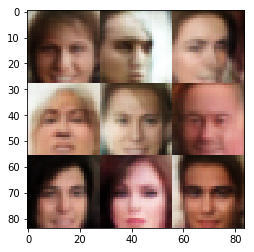

Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 3.0446
Epoch 1/1... Discriminator Loss: 0.0695... Generator Loss: 3.5696
Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 3.5138
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 3.0783
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 4.7422
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 4.1599
Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 3.4497
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 4.7430
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.5178


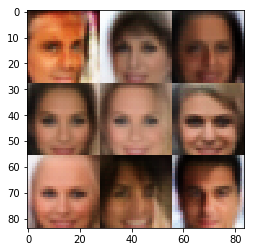

Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 4.0274
Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 3.6265
Epoch 1/1... Discriminator Loss: 0.1055... Generator Loss: 3.7633


In [102]:
batch_size = 24
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.